# Explorer les données d'OpenFoodFacts

Nous allons explorer le jeu de données d'OpenFoodFacts, filtré pour ne conserver que les produits vendus en France et les champs remplis pour au moins 1000 produits, dont les fiches sont marquées "complètes" et contiennent un nom de produit et une marque.

In [1]:
import pandas as pd

In [2]:
# modifier le chemin vers le fichier CSV si nécessaire
# ici on utilise le fichier filtré dans le notebook précédent
CSV_FILE = '../data/off_subset.csv'

In [3]:
# on charge les types de données qu'on a spécifiés dans le notebook 1
DTYPE_FILE = '../data/dtype.txt'
with open(DTYPE_FILE) as f:
    dtype = eval(f.read())
dtype

{'origins': 'category',
 'origins_tags': 'category',
 'first_packaging_code_geo': 'category',
 'cities_tags': 'category',
 'purchase_places': 'category',
 'countries': 'category',
 'countries_tags': 'category',
 'countries_en': 'category',
 'traces_tags': 'category',
 'traces_en': 'category',
 'additives': 'category',
 'ingredients_from_palm_oil_tags': 'category',
 'ingredients_that_may_be_from_palm_oil_tags': 'category',
 'nutriscore_grade': 'category',
 'pnns_groups_1': 'category',
 'pnns_groups_2': 'category',
 'states': 'category',
 'states_tags': 'category',
 'states_en': 'category',
 'cities': 'float16',
 'allergens_en': 'float16',
 'serving_quantity': 'float16',
 'no_nutriments': 'float16',
 'additives_n': 'float16',
 'ingredients_from_palm_oil_n': 'float16',
 'ingredients_from_palm_oil': 'float16',
 'ingredients_that_may_be_from_palm_oil_n': 'float16',
 'ingredients_that_may_be_from_palm_oil': 'float16',
 'nutriscore_score': 'float16',
 'nova_group': 'float16',
 'energy-kj_100g

In [4]:
df_off = pd.read_csv(CSV_FILE, sep='\t', dtype=dtype)
df_off.info(memory_usage='deep')

/home/mathieu/miniconda3/envs/off-explore/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90738 entries, 0 to 90737
Columns: 101 entries, code to nutrition-score-uk_100g
dtypes: category(18), float16(44), int64(2), object(37)
memory usage: 337.0 MB


## Exploration et nettoyage avec OpenRefine

La méthode la plus simple pour explorer le contenu du jeu de données est d'utiliser un outil graphique comme OpenRefine, qui permet aussi et surtout de nettoyer un jeu de données de façon reproductible.

### Présentation et installation d'OpenRefine

OpenRefine est un outil graphique, open source, pour travailler sur des jeux de données sales.
Cet outil permet de nettoyer un jeu de données de façon semi-automatique, par itérations successives.
OpenRefine stocke l'historique des opérations de nettoyage que vous appliquez et vous permet de l'exporter pour le rejouer, sur le même jeu de données ou sur une autre version de ce jeu de données.

Je vous conseille de visionner les 3 captures vidéo de la documentation officielle, qui donne une bonne idée de ce que vous pouvez réaliser avec OpenRefine.
https://github.com/OpenRefine/OpenRefine/wiki/Screencasts

Vous pouvez télécharger OpenRefine depuis cette page :
https://openrefine.org/download.html

### Lancement d'OpenRefine
Une fois que vous avez téléchargé et installé OpenRefine, vous pouvez ouvrir le fichier CSV filtré (tous les produits d'OpenFoodFacts distribués en France, restreint aux colonnes contenant plus de 1000 valeurs).

Par défaut, OpenRefine s'alloue 1 Go de RAM, ce qui est insuffisant pour notre fichier.
Il y a deux solutions:
1. Allouer plus de RAM pour ouvrir le fichier ;
2. Exporter en CSV un sous-ensemble plus restreint du jeu de données, contenant moins de lignes ou moins de colonnes.

#### Option 1: Allouer plus de RAM
On modifie les paramètres de lancement d'OpenRefine: https://github.com/OpenRefine/OpenRefine/wiki/FAQ:-Allocate-More-Memory

Par exemple :
```sh
# 4096 Mo = 4 Go de RAM
./refine -m 4096m
```

#### Option 2: Exporter un sous-ensemble du jeu de données
Nous allons exporter une fraction de l'ensemble de produits, par exemple les 900 premières fiches de produits laitiers ('en:dairies').

In [30]:
# on prend les 900 premières fiches
df_sub = df_off[df_off['categories_tags'].str.contains('en:dairies')][:900]
print(df_sub.shape)
# on fait un dump CSV du jeu de données filtré
SEL_FILE = '../data/off_small.csv'
df_sub.to_csv(SEL_FILE, sep='\t', index=False)

(900, 101)


### Utilisation d'OpenRefine

Ouvrir le fichier.

Dans la fenêtre de configuration des options de parsing:
- vérifier que le séparateur (tab), la ligne d'en-tête... sont correctement détectés ;
- cocher la case "Parse cell text into numbers, dates..." pour mieux visualiser et manipuler ces types de données ;
- appuyer sur "create project" (en haut à droite).

L'import des données ne prend normalement que quelques secondes.
Si le temps d'import estimé augmente et se compte en minutes, c'est que vous n'avez pas alloué suffisamment de RAM ou que vous essayez de charger un fichier trop gros (retour à l'option 1 ou 2 ci-dessus).

Nous pouvons créer une facette pour examiner une colonne, par exemple la colonne contenant les marques.

La facette met en évidence que parmi les plus de 60000 valeurs distinctes se trouvent de nombreuses variantes graphiques de la même marque.
L'utilisation d'une méthode de clustering dans une facette permet de regrouper et fusionner ces variantes par paquets.

Par exemple, combien y a-t-il de variantes pour la marque "Nos régions ont du talent, Leclerc" ?

Quelles sont les informations disponibles pour chaque cluster ?

Pour la méthode de clustering "key collision":
- Quelles "keying functions" sont disponibles?
- Comment fonctionnent-elles?
- Produisent-elles des clusterings similaires?
- Pourquoi?

## Exploration avec dirty_cat

```sh
# quand la version 0.0.6 sera sortie:
# pip install --user dirty_cat
# en attendant on installe depuis la pointe de la branche sur le dépôt github
pip install --user -U git+git://github.com/dirty-cat/dirty_cat.git#egg=dirty_cat
```

https://dirty-cat.github.io/stable/auto_examples/01_investigating_dirty_categories.html

In [31]:
df_sub['product_name'].value_counts().sort_index()

0% fat Greek style yogurt               1
10 tranches Emmental français           1
12 petits fromages de chèvre doux       1
2 Clotted Cream Rice Puddings           1
4 chèvre chauds                         1
                                       ..
yaourt 0,1% myrtille                    1
yaourt au lait de brebis                1
yaourt aux fruits                       1
yaourt bio au lait de brebis nature.    1
yaourt nature                           1
Name: product_name, Length: 795, dtype: int64

In [32]:
sorted_values = df_sub['product_name'].sort_values().unique()

In [33]:
from dirty_cat import SimilarityEncoder

similarity_encoder = SimilarityEncoder(similarity='ngram')
transformed_values = similarity_encoder.fit_transform(
    sorted_values.reshape(-1, 1))
transformed_values.shape

(795, 795)

Pour mieux comprendre la représentation créée par l'encodeur de similarité, nous pouvons afficher quelques noms de produits sur un graphe en 2 dimensions (en utilisant une méthode de réduction de dimensionalité!).

In [34]:
from sklearn.manifold import MDS

mds = MDS(dissimilarity='precomputed', n_init=10, random_state=42)
two_dim_data = mds.fit_transform(
    1 - transformed_values)  # transformed values lie
# in the 0-1 range, so 1-transformed_value yields a positive dissimilarity matrix
print(two_dim_data.shape)
print(sorted_values.shape)

(795, 2)
(795,)


On ajuste un modèle de k plus proches voisins (kNN) pour éviter de surcharger le graphe.

In [41]:
import numpy as np

n_points = 5
np.random.seed(43)
from sklearn.neighbors import NearestNeighbors

random_points = np.random.choice(len(similarity_encoder.categories_[0]),
                                 n_points, replace=False)
nn = NearestNeighbors(n_neighbors=2).fit(transformed_values)
_, indices_ = nn.kneighbors(transformed_values[random_points])
indices = np.unique(indices_.squeeze())

Puis on dessine le graphe en ajoutant les catégories de départ (ici les noms de produits).

Text(0.5, 1.0, 'multi-dimensional-scaling representation using a 3gram similarity matrix')

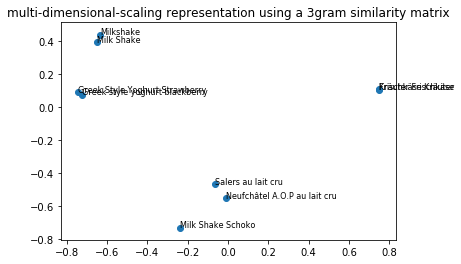

In [42]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()
ax.scatter(x=two_dim_data[indices, 0], y=two_dim_data[indices, 1])
# adding the legend
for x in indices:
    ax.text(x=two_dim_data[x, 0], y=two_dim_data[x, 1], s=sorted_values[x],
            fontsize=8)
ax.set_title(
    'multi-dimensional-scaling representation using a 3gram similarity matrix')

### Heatmap de la matrice de similarité

Nous pouvons afficher la matrice de similarité pour ces observations.

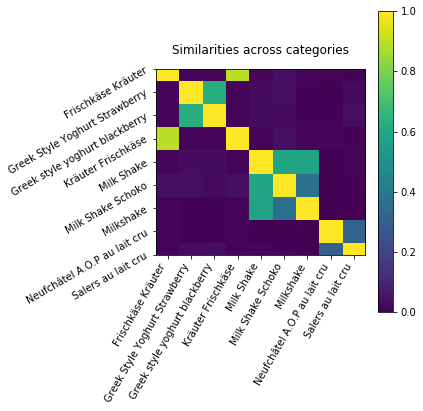

In [43]:
f2, ax2 = plt.subplots(figsize=(6, 6))
cax2 = ax2.matshow(transformed_values[indices, :][:, indices])
ax2.set_yticks(np.arange(len(indices)))
ax2.set_xticks(np.arange(len(indices)))
ax2.set_yticklabels(sorted_values[indices], rotation='30')
ax2.set_xticklabels(sorted_values[indices], rotation='60', ha='right')
ax2.xaxis.tick_bottom()
ax2.set_title('Similarities across categories')
f2.colorbar(cax2)
f2.tight_layout()

## Geopandas

Le champ `first_packaging_code_geo` contient des coordonnées géographiques.

Il est donc possible de dessiner une carte avec `geopandas`:
https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html

In [5]:
# TODO dessiner une carte à partir de first_packaging_code_geo

## Exploration par facettes liées ?

https://seaborn.pydata.org/tutorial/relational.html#showing-multiple-relationships-with-facets

## Réduction de dimensionalité

Nous utiliserons une implémentation efficace de t-SNE: [openTSNE](https://github.com/pavlin-policar/openTSNE/).

```sh
conda install --channel conda-forge opentsne
```

In [ ]:
from openTSNE import TSNE
df_nutri = df_sub[['']]
embedding = TSNE().fit(x)